In [ ]:
# 패키지 설치
!pip install -q -U "google-generativeai>=0.7.2"

In [ ]:
from google.colab import userdata
import google.generativeai as genai

# 환경 변수 준비(좌측 하단의 열쇠 아이콘으로 GOOGLE_API_KEY 설정)
GOOGLE_API_KEY=userdata.get("GOOGLE_API_KEY")
genai.configure(api_key=GOOGLE_API_KEY)

### 파인 튜닝이 완료된 모델 목록 가져오기

In [ ]:
import google.generativeai as genai

# 파인 튜닝이 완료된 모델 목록 가져오기
for model in genai.list_tuned_models():
    print(model.name)

### 학습 데이터 준비

In [ ]:
# 제미나이가 지원하는 학습 데이터 형식으로 변환
training_data = []
with open("train.csv", "r") as file:
    next(file)  # 첫 번째 줄(헤더)을 건너뜁니다.
    for line in file:
        strs = line.strip().split(",")
        training_data.append({"text_input": strs[0], "output": strs[1]})
print(training_data)

[{'text_input': '오늘 날씨 어때?', 'output': '오늘은 맑고 화창한 날씨네요. 외출하기 좋겠어요!'}, {'text_input': '뭐 먹지?', 'output': '오늘은 어떤 음식이 땡기세요? 매콤한 떡볶이 어떠세요? 아니면 시원한 냉면은?'}, {'text_input': '영화 추천해줘', 'output': '"어떤 장르의 영화를 좋아하세요? 액션'}, {'text_input': '요즘 인기 있는 드라마 뭐 있어?', 'output': "요즘 인기 있는 드라마로는 '더 글로리'가 있어요. 시청자들 사이에서 반응이 좋더라구요!"}, {'text_input': '주식 시장 어때?', 'output': '오늘 주식 시장은 혼조세를 보이고 있어요. 주요 종목을 잘 살펴보세요!'}, {'text_input': '요즘 유행하는 패션 스타일은?', 'output': '요즘은 미니멀리즘 스타일이 유행이에요. 심플하면서도 고급스러운 룩이 인기랍니다.'}, {'text_input': '오늘 할 일 알려줘', 'output': '오늘은 미팅 준비와 프로젝트 보고서 작성을 해야 해요. 파이팅입니다!'}, {'text_input': 'AI가 뭐야?', 'output': '"AI는 인공지능으로'}, {'text_input': '주말에 뭐 하면 좋을까?', 'output': '"주말에는 가까운 공원에서 산책하거나'}, {'text_input': '새로운 책 추천해줘', 'output': "최근 인기 있는 책으로는 '달러구트 꿈 백화점'이 있어요. 흥미로운 내용이 많답니다."}, {'text_input': '건강하게 사는 방법 알려줘', 'output': '규칙적인 운동과 균형 잡힌 식단이 중요해요. 하루에 물도 충분히 마시고 스트레스를 줄이는 것도 좋아요.'}, {'text_input': '외국어 공부 어떻게 하면 좋을까?', 'output': '매일 조금씩 꾸준히 하는 게 중요해요. 좋아하는 영화나 음악을 원어로 접하는 것도 추천해요!'}, {'text_i

### 학습

In [ ]:
import google.generativeai as genai

# 사전 학습 모델 준비
base_model = [
    m for m in genai.list_models()
    if "createTunedModel" in m.supported_generation_methods][0]
base_model

Model(name='models/gemini-1.5-flash-001-tuning',
      base_model_id='',
      version='001',
      display_name='Gemini 1.5 Flash 001 Tuning',
      description='Fast and versatile multimodal model for scaling across diverse tasks',
      input_token_limit=16384,
      output_token_limit=8192,
      supported_generation_methods=['generateContent', 'countTokens', 'createTunedModel'],
      temperature=1.0,
      max_temperature=2.0,
      top_p=0.95,
      top_k=64)

In [ ]:
import random

# 학습 시작
name = f'generate-num-{random.randint(0,10000)}'
operation = genai.create_tuned_model(
    source_model=base_model.name,
    training_data=training_data,
    id = name,
    epoch_count = 100,
    batch_size=4,
    learning_rate=0.001,
)

In [ ]:
# 모델 불러오기
model = genai.get_tuned_model(f'tunedModels/{name}')

# 모델 상태 확인
print(model.state)
print(operation.metadata)

State.CREATING
total_steps: 7500
tuned_model: "tunedModels/generate-num-9866"



In [ ]:
import time

# 학습 진행 상황 표시
for status in operation.wait_bar():
    time.sleep(30)

  0%|          | 0/7500 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# operation.cancel()

<Axes: xlabel='epoch', ylabel='mean_loss'>

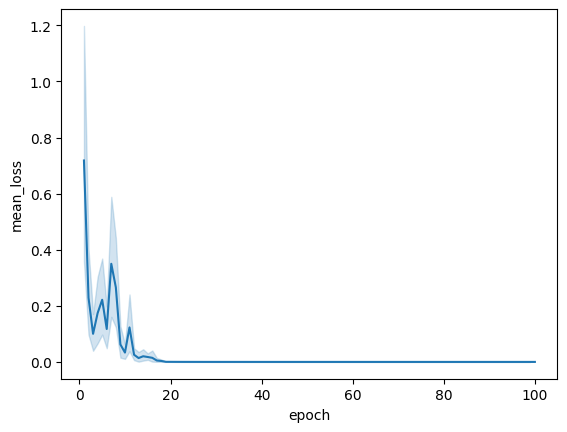

In [ ]:
import pandas as pd
import seaborn as sns

# 학습 결과를 학습 곡선으로 확인
model = operation.result()
snapshots = pd.DataFrame(model.tuning_task.snapshots)
sns.lineplot(data=snapshots, x = "epoch", y="mean_loss")

### 추론

In [ ]:
# 모델 불러오기
model = genai.GenerativeModel(model_name=f"tunedModels/{name}")

In [ ]:
# 추론 실행
result = model.generate_content("좋아하는 음식이 뭐야?")
result.text

'저는 다양한 음식을 좋아해요. 매콤한 떡볶이부터 시원한 냉면까지 모두 맛있어요!'

### 파인 튜닝이 모델 설명 업데이트

In [ ]:
# 설명 업데이트
genai.update_tuned_model(f"tunedModels/{name}", {"description":"This is my model."});

In [ ]:
# 업데이트된 설명 확인
model = genai.get_tuned_model(f"tunedModels/{name}")
model.description

'This is my model.'

### 파인 튜닝 모델 삭제

In [ ]:
# 삭제
genai.delete_tuned_model(f"tunedModels/{name}")

### OAuth 인증으로 Gemini API 준비

In [ ]:
from google.colab import userdata
import pathlib
pathlib.Path("client_secret.json").write_text(userdata.get("CLIENT_SECRET"))

402

In [ ]:
!gcloud auth application-default login \
    --no-browser --client-id-file client_secret.json \
    --scopes='https://www.googleapis.com/auth/cloud-platform,https://www.googleapis.com/auth/generative-language.tuning,https://www.googleapis.com/auth/generative-language.retriever'

You are authorizing client libraries without access to a web browser. Please run the following command on a machine with a web browser and copy its output back here. Make sure the installed gcloud version is 372.0.0 or newer.

gcloud auth application-default login --remote-bootstrap="https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=336676337320-39l2n3cr440eenf8rl1e95tfqoq42de8.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fgenerative-language.tuning+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fgenerative-language.retriever&state=xh3o3hq3IAH6KlWjbaheADQI9xWcWj&access_type=offline&code_challenge=razJyHjuu6XdAv3hDEZa2FNeHKe-NvBVh5g415xDfDg&code_challenge_method=S256&token_usage=remote"


Enter the output of the above command: https://localhost:8085/?state=xh3o3hq3IAH6KlWjbaheADQI9xWcWj&code=4/0AVG7fiTwiBuSSMNEOz_oiQJIkpdWvGprgkulhpt5ZCdfkVOfzoJxu1D7bHS1-a4nELmdVg&scope=https://www.googl